# Similarity-Based Link Prediction on Yelp Recommender

In [1]:
from random import choices
from itertools import combinations
from collections import defaultdict 

import numpy as np
import pandas as pd

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Data Import

In [2]:
busi_df = pd.read_feather("data/yelp_business_cleaned.feather")
print(f"There are {busi_df.shape[0]} business records with {busi_df.shape[1]} total features.")
display(busi_df.head(3))
busi_df[['stars', 'review_count']].describe()

There are 68054 business records with 84 total features.


,original_index,business_id,name,address,city,state,postal_code,latitude,longitude,stars,...,music_live,music_video,music_karaoke,hours_Monday,hours_Tuesday,hours_Wednesday,hours_Thursday,hours_Friday,hours_Saturday,hours_Sunday
0,3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,...,None,None,None,7:0-20:0,7:0-20:0,7:0-20:0,7:0-20:0,7:0-21:0,7:0-21:0,7:0-21:0
1,4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,...,None,None,None,closed,closed,14:0-22:0,16:0-22:0,12:0-22:0,12:0-22:0,12:0-18:0
2,5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,...,None,None,None,0:0-0:0,6:0-22:0,6:0-22:0,6:0-22:0,9:0-0:0,9:0-22:0,8:0-22:0


,stars,review_count
count,68054.000000,68054.000000
mean,3.563949,74.619861
std,0.851437,169.900997
min,1.000000,5.000000
25%,3.000000,11.000000
50%,3.500000,27.000000
75%,4.000000,73.000000
max,5.000000,7568.000000


In [3]:
busi_df.groupby('state')['original_index'].count()

state
AB     3048
AZ     3579
CA     1695
DE     1171
FL    11476
ID     1798
IL     1198
IN     5374
LA     4888
MO     5366
NJ     4216
NV     2462
PA    16170
TN     5613
Name: original_index, dtype: int64

### Filter only businesses in PA and FL for computation due to resource contraints

In [4]:
busi_df = busi_df[busi_df['state'].isin(['PA', 'FL'])]

In [25]:
print(f"There are {len(busi_df)} businesses left in the data")

There are 27646 businesses left in the data


### Get review data

In [ ]:
review_df = pd.read_feather("data/yelp_review.feather")
review_df = review_df.loc[review_df['business_id'].isin(busi_df['business_id'])].copy()
print(f"There are {review_df.shape[0]} review records with {review_df.shape[1]} total features.")
display(review_df.head(3))

# Network Construction

In this network, vertices represent businesses, and an edge between vertex $i$ and $j$ indicates that these two businesses are similar. We will determine whether there is an edge between $i$ and $j$ based on the number of users who have visited these two places (and thus wrote a review on them). If more users visit both places, then it is likely that the two businesses are somehow similar.

## Edge determination

For any business $i$ and $j$, count the number of users who have been to these $2$ places based on the review data.


First, for each user, find all business ids that they have reviewed on.

In [6]:
visit_by_user = review_df.groupby('user_id')['business_id'].apply(list).to_frame()
print(f"There're {len(visit_by_user)} users")
visit_by_user

There're 588266 users


,business_id
user_id,
---2PmXbF47D870stH1jqA,"[hKameFsaXh9g8WQbv593UA, hKameFsaXh9g8WQbv593U..."
---r61b7EpVPkb4UVme5tA,"[fGYnHzFr1z2kv7bPRW6VMA, 5UN1B7XqZohGuULLNlWL1..."
--0kuuLmuYBe3Rmu0Iycww,"[qcguEeAMP0XwFLYqhwX2hg, Y5S_AUSW8EjswVf9JAi-0w]"
--13zE3NaRvLSrmfTVnFJA,[U2y7fsqDgxAXskoJNVxbwg]
--1oZcRo9-QKOtTqREKB6g,"[p_qSQwShIgQnNxGcajI4-w, QHWYlmVbLC3K6eglWoHVvA]"
...,...
zzwYLnmIvj8C7wJmRjtkRA,"[j-qtdD55OLfSqfsWuQTDJg, pXRrRf8fDv6yU3xp1E25hA]"
zzx7J3zheFF3zf5YYfDAMg,[pm1bStJuol5XmxE_atZhCQ]
zzxCh58BAynQseL1rUlJqg,[tOPDno-cu5NQO56FeOBg-g]


Delete users that have reviewed only on one business (since they don't contribute to the existence of an edge).

In [7]:
visit_by_user = visit_by_user[visit_by_user['business_id'].apply(len) > 1].reset_index()
print(f"There're {len(visit_by_user)} users left after the filter")
visit_by_user

There're 252118 users left after the filter


,user_id,business_id
0,---2PmXbF47D870stH1jqA,"[hKameFsaXh9g8WQbv593UA, hKameFsaXh9g8WQbv593U..."
1,---r61b7EpVPkb4UVme5tA,"[fGYnHzFr1z2kv7bPRW6VMA, 5UN1B7XqZohGuULLNlWL1..."
2,--0kuuLmuYBe3Rmu0Iycww,"[qcguEeAMP0XwFLYqhwX2hg, Y5S_AUSW8EjswVf9JAi-0w]"
3,--1oZcRo9-QKOtTqREKB6g,"[p_qSQwShIgQnNxGcajI4-w, QHWYlmVbLC3K6eglWoHVvA]"
4,--2bpE5vyR-2hAP7sZZ4lA,"[BjBDHqHhMXSxgyVipccznQ, TV81bpCQ6p6o4Hau5hk-z..."
...,...,...
252113,zzrhWsiCwAKQzbgMZIOtgg,"[vpLMV6pHa1oI71jYaCVFzA, zvixukO8M4PCmMMaZOldPg]"
252114,zzu2hGJ6O9mP5yg6fjtvzg,"[4bvQThX0cJxlx67PU9nmLQ, TwnzM8mJn_nT2PJf1x-9k..."
252115,zzvCl_egPyWpxO7EvWc2IA,"[pW5DXTpKnw3y0fopipbJVg, t9P1At2Cw8PO5NdjIZjrK..."
252116,zzw0Z6-_VDp9ShIRSKIsQw,"[9kjcWWo0pZ5qr1ZpAXBFnQ, gpTC5qka3HCQqnSyXloph..."


For any pair of businesses $b1$ and $b2$, count the number of users in the review data who have visited both places. This is stored in a dictionary `edge_count` with tuple `(b1, b2)` (alphabetically sorted between b1 and b2) as keys and `num_users` as values.

In [8]:
edge_count = {}
for index, row in visit_by_user.iterrows():
    for b1, b2 in combinations(sorted(row['business_id']), 2):
        if (b1, b2) not in edge_count:
            edge_count[b1, b2] = 1
        else:
            edge_count[b1, b2] += 1
    if index % 10000 == 0:
        print(f"...{index}")

...0
...10000
...20000
...30000
...40000
...50000
...60000
...70000
...80000
...90000
...100000
...110000
...120000
...130000
...140000
...150000
...160000
...170000
...180000
...190000
...200000
...210000
...220000
...230000
...240000
...250000


In [9]:
print(f"Total number of business pairs: {len(edge_count)}")

Total number of business pairs: 20653315


In [10]:
busi_pairs = edge_count.keys()
num_users = edge_count.values()
busi1 = [b[0] for b in busi_pairs]
busi2 = [b[1] for b in busi_pairs]
edge_df = pd.DataFrame({'b1': busi1,
                        'b2': busi2,
                        'num_users': num_users})
edge_df

,b1,b2,num_users
0,0ZsqqzHu1HHkDdIKoivi5g,1An4DxtMmvvSe0HX4viRCA,4
1,0ZsqqzHu1HHkDdIKoivi5g,3YqUe2FTCQr0pPVK8oCv6Q,105
2,0ZsqqzHu1HHkDdIKoivi5g,3gXgILE2YWVidJDvVWBT6Q,6
3,0ZsqqzHu1HHkDdIKoivi5g,HpWi2CRJlxVCYKd8kS0X-A,4
4,0ZsqqzHu1HHkDdIKoivi5g,KP5OncF2jhT7_J1phHPPww,69
...,...,...,...
20653310,KzSL2VzyT7bdHd0bhMyanw,sQhh7JCGpqNgf0hHWc4m8g,1
20653311,KzSL2VzyT7bdHd0bhMyanw,t9P1At2Cw8PO5NdjIZjrKA,1
20653312,pW5DXTpKnw3y0fopipbJVg,t9P1At2Cw8PO5NdjIZjrKA,1
20653313,9kjcWWo0pZ5qr1ZpAXBFnQ,d9gvn2Nu_0qFzQLhAP9XFQ,1


In [14]:
edge_df.sort_values('num_users', ascending = False, inplace = True)

In [12]:
edge_df.to_feather("data/business_edge_user_count.feather")

### Construct the network graph

Vertices = businesses (approximately 27K businesses)

Edges = There's an edge between $i$ and $j$ if the number of users are more than xx.

Note: See https://networkx.org/documentation/latest/reference/introduction.html#networkx-basics for `nx` package documentation

To determine an edge, look at the distribution of `num_users`.

Couldn't plot a histogram, probably because it's highly skewed

In [2]:
edge_df = pd.read_feather("data/business_edge_user_count.feather")

In [3]:
edge_df.describe()

,num_users
count,2.065332e+07
mean,2.321564e+00
std,3.913244e+00
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,1.446000e+03


/Users/runlanlana/opt/anaconda3/envs/ds_harvard/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


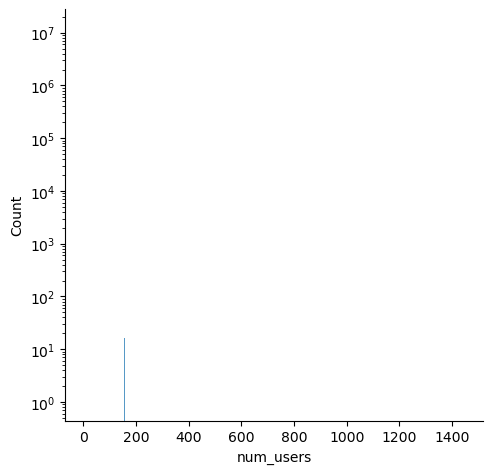

In [22]:
sns.displot(data = edge_df, x = "num_users")
plt.yscale('log')

In [26]:
for cutoff in [1, 5, 10, 20, 50, 100]:
    print(f"If cutoff = {cutoff}, there will be {len(edge_df[edge_df['num_users'] >= cutoff])} edges")

If cutoff = 1, there will be 20653315 edges
If cutoff = 5, there will be 1974099 edges
If cutoff = 10, there will be 588147 edges
If cutoff = 20, there will be 151273 edges
If cutoff = 50, there will be 18145 edges
If cutoff = 100, there will be 2471 edges


Since there's about 27K businesses (vertices), probably should take the cutoff = 5 for the existence of an edge

In [4]:
cutoff = 5
edge_subset = edge_df[edge_df['num_users'] >= cutoff]
edge_list = list(zip(*map(edge_subset.get, ['b1', 'b2', 'num_users'])))

In [5]:
G = nx.Graph()
G.add_weighted_edges_from(edge_list) # or use G.add_edges_from(edge_list) for unweifhted graph

In [ ]:
deg_assort = nx.degree_assortativity_coefficient(G, x = 'out', y = 'out')
print(f"The network has degree assortativity: {deg_assort}")

In [ ]:
nx.degree_histogram(G)

This graph will be referred to as "fully observed graph"

## Network visualization

In [ ]:
elarge = [(u, v) for (u, v, d) in G.edges(data = True) if d["weight"] > 100]
esmall = [(u, v) for (u, v, d) in G.edges(data = True) if d["weight"] <= 100]

pos = nx.spring_layout(G)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# edges
nx.draw_networkx_edges(G, pos, edgelist = elarge, width=6)
nx.draw_networkx_edges(
    G, pos, edgelist = esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
)

# node labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# # G = nx.cubical_graph()
# plt.clf()
# subax1 = plt.subplot(121)
# nx.draw(G)   # default spring_layout
# # nx.draw(G, pos=nx.circular_layout(G), node_color='r', edge_color='b')

## Split Train and Test

Randomly select 25% of the existing edges to reserve as the test set $E_T$. The train network will include all vertices and the edges $E-E_T$. The task is to predict the edges in $E_T$ given the similarities among existing nodes in `g_train`.

In [ ]:
train_edges, test_edges = train_test_split(edge_list, test_size = 0.25)
# g_train = nx.induced_subgraph(G, selected_nodes)
g_train = nx.Graph()
g_train.add_nodes_from(G.nodes)
g_train.add_weighted_edges_from(test_edges)

## Compute similarity scores using different approaches